In [87]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
from pricing_tools import *
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Leemos el diccionario de variables

In [2]:
dict_path=r'../src/data_dict.xlsx'
dict = pd.read_excel(dict_path)
dict.head()

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.0,0,1.0,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.0,0,1.0,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.0,0,1.0,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.0,0,1.0,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.0,0,1.0,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA


### Leemos el dataframe

In [3]:
df_path=r'../src/AGUAACAGBC'
df=pd.read_parquet(df_path)
df.head()

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,...,zona_inundable_centroids,zonas_agri,zonas_de_extraccion_minera,zonas_en_construccion,zonas_fore,zonas_hume,zonas_industriales_o_comerciales,zonas_portuarias,zonas_quemadas,zonas_verdes_urbanas
0,1033.0,552.0,31.0,NaN,31.0,99.0,4.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
1,1033.0,552.0,30.0,NaN,30.0,99.0,3.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
2,1033.0,552.0,33.0,NaN,33.0,99.0,6.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
3,1033.0,552.0,34.0,NaN,34.0,99.0,7.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
4,1033.0,552.0,36.0,NaN,36.0,99.0,6.0,1961.0,1961.0,0.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN


In [4]:
#Por si llegase a ser necesario reducir el tamaño del df para el analisis
df_muestra = df.sample(n=len(df))

In [5]:
###Definimos las variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

In [6]:
df_muestra=df_muestra[df_muestra[peso]>0]

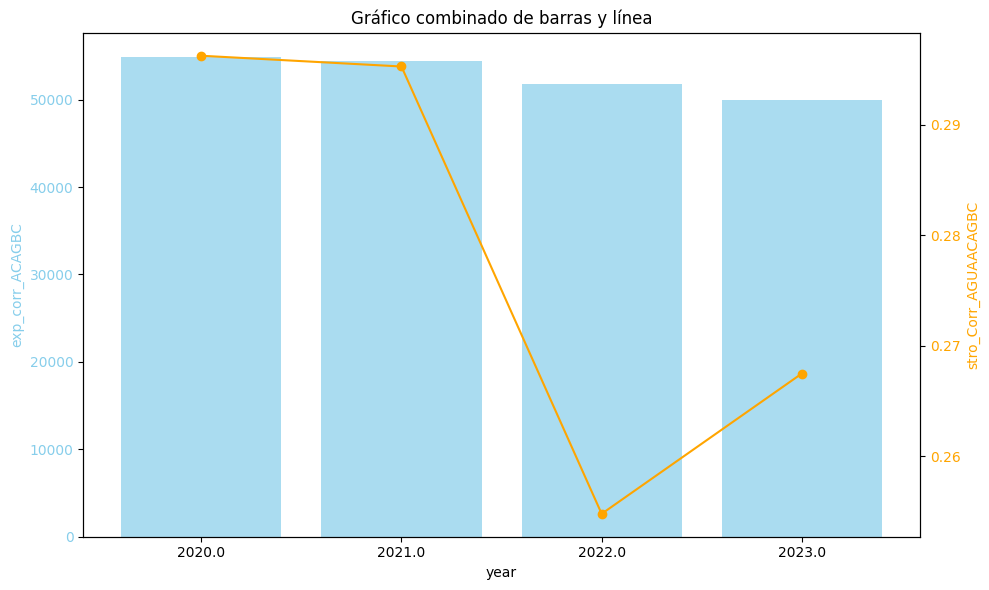

In [7]:
#Estudiamos la composicion de l cartera por años
df_muestra[ano]=df_muestra[ano].astype(str)
df_resumido = df_muestra.groupby(ano).agg({peso: 'sum', var_resp: 'mean'}).reset_index()
graficar_barras_linea(df_resumido,ano,peso,var_resp)

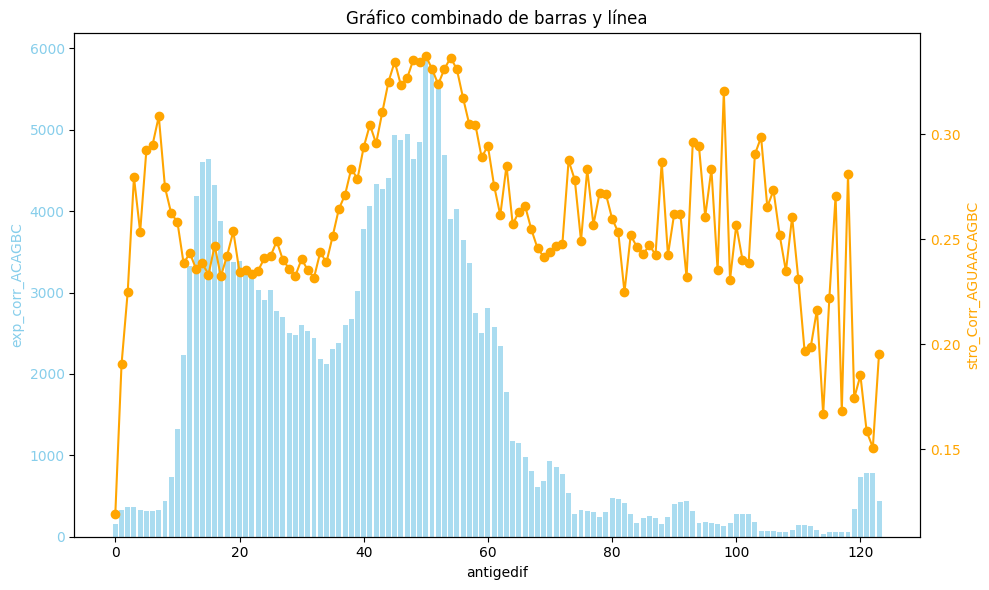

In [8]:
### Ejemplo variable importante 
##Antiguedad del edificio
var='antigedif'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', var_resp: 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,var_resp)

In [9]:
antig_corregida=generar_formato_exposicion_homogenea(df_muestra, 'antigedif', peso, 10)
df_muestra['antigedif_2']=antig_corregida #Sobreescribimos la columna corregida

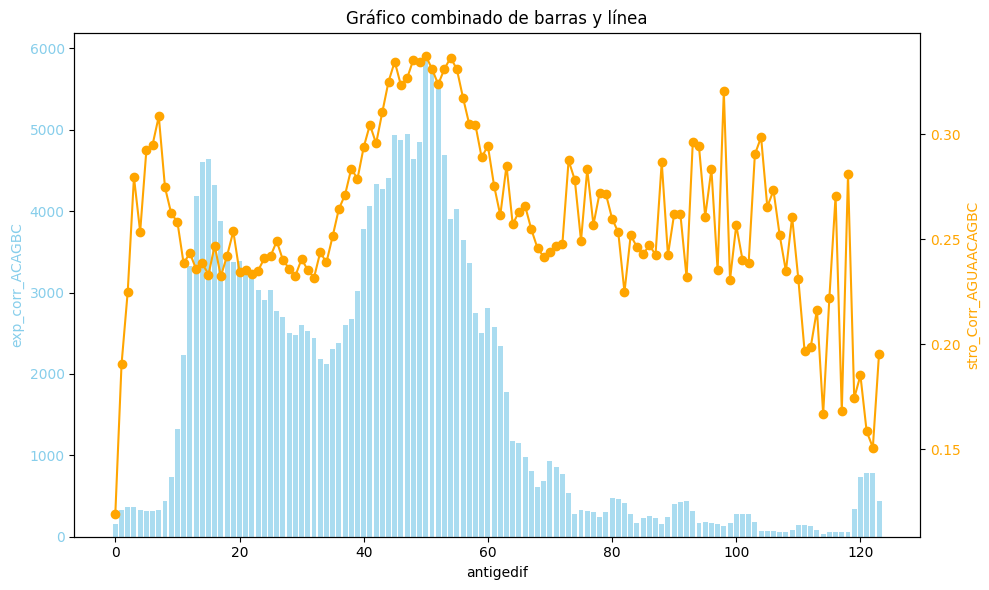

In [10]:
df_muestra['antigedif_2']=df_muestra['antigedif_2'].astype(str)
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', var_resp: 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,var_resp)

In [11]:
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['antigedif_2'].replace('nan',np.nan).mode(dropna=True)[0]

'(51.0, 56.0]'

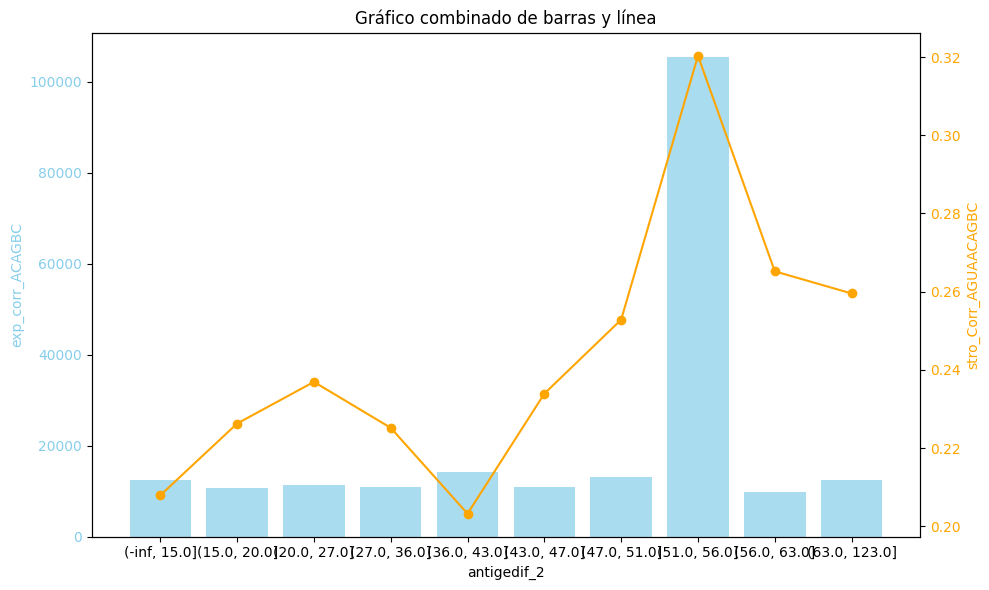

In [21]:
### Ahora sustituimos los nan por el valor moda
df_muestra['antigedif_2']=df_muestra['antigedif_2'].replace('nan','(51.0, 56.0]')
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', var_resp: 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,var_resp)

In [79]:
###Implementación basica del modelo LGBM

# Separar características (X), la variable objetivo (y) y la columna de exposición (weights)
#cols_features = [col for col in df_muestra.columns if col!=var_resp or col!=peso]
df_model=df_muestra.copy()
df_model['antigedif_2']=LabelEncoder().fit_transform(y=df_model['antigedif_2'])
df_model['year']=LabelEncoder().fit_transform(y=df_model['year'])
df_model['NIF_TIPO']=LabelEncoder().fit_transform(y=df_model['NIF_TIPO'])
cols_features=['year','antigedif_2','anualidad_seguro','FP','K_ACAGBC','SUPERFICIE','stro_1a_AGUAACAGBC','NIF_TIPO']###Se evaluan ciclicamente
X = df_model[cols_features]
y = df_model[var_resp]
weights = df_model[peso]  # Exposición como "weights"

In [80]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

In [81]:
# Crear un dataset de LightGBM con el conjunto de entrenamiento
train_data = lgb.Dataset(X_train, label=y_train, weight=weights_train)

In [82]:
# Parámetros del modelo
params = {
    'objective': 'binary',  # Dado que es un problema de clasificación binaria (0 y 1)
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',  # Tipo de boosting
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=100)

# Hacer predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir probabilidades a 0 o 1

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7306


In [83]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

Matriz de Confusión:
[[75683  2568]
 [26649  3533]]


In [84]:
# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(class_report)


Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84     78251
         1.0       0.58      0.12      0.19     30182

    accuracy                           0.73    108433
   macro avg       0.66      0.54      0.52    108433
weighted avg       0.69      0.73      0.66    108433



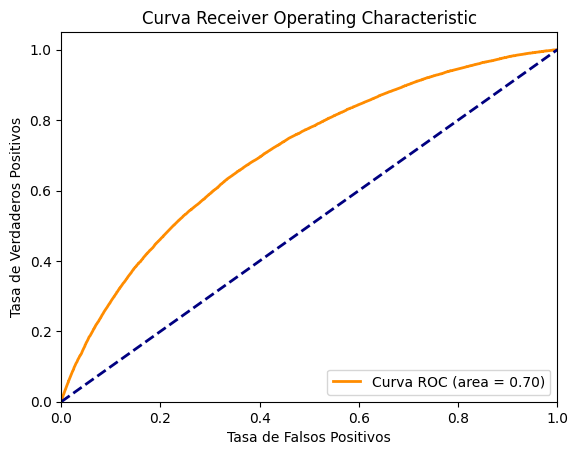

In [85]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [86]:
# Obtener la importancia de las características
feature_importances = model.feature_importance(importance_type='gain')

# Crear un DataFrame para visualizar
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
5,SUPERFICIE,65468.095399
6,stro_1a_AGUAACAGBC,33784.593836
4,K_ACAGBC,13696.201648
1,antigedif_2,7661.350989
2,anualidad_seguro,4879.553780
7,NIF_TIPO,4189.885798
0,year,2093.843958
3,FP,962.163380


In [99]:
###Micro-zonificación
MZ_cols=list(dict[dict['CATEGORÍA'].isin(['06.Geográfica','07. Externas_1'])]['Factores'])
not_cols=['CODINE','CODPOST','codigo_grp'] #Columnas que son llave primaria para unir el resultado final al df_modelo
MZ_cols=[col for col in MZ_cols if col not in not_cols]

In [102]:
df_model[MZ_cols].isna().sum().sort_values(ascending=False)

dias_maxima_bajo_cero_invier       497881
dias_minima_bajo_menos10_invier    494613
dias_insolacion_season_otono       465169
dias_prec_verano_extrem            457202
dias_prec_primav_extrem            455022
                                    ...  
PREC_E_OBS_100Y                         0
PREC_E_OBS_5Y                           0
PREC_E_OBS_50Y                          0
PREC_E_OBS_25Y                          0
PREC_E_OBS_10Y                          0
Length: 263, dtype: int64

In [103]:
len(df_model_MZ)

0

In [98]:
# Normalizar los datos
scaler = StandardScaler()
df_model_MZ=df_model[MZ_cols].dropna()
scaled_data = scaler.fit_transform(df_model_MZ)

ValueError: Found array with 0 sample(s) (shape=(0, 263)) while a minimum of 1 is required by StandardScaler.

In [96]:
# Aplicar PCA
pca = PCA(n_components=1)  # Reduciendo a 1 componentes principales
pca_result = pca.fit_transform(scaled_data)

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [ ]:
# Crear un DataFrame con los resultados del PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])